In [22]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh, eigvalsh
#from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib as mpl
#plt.style.use('dark_background')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size']=18
#from scipy.linalg import expm, sqrtm
#from scipy.stats import linregress
from math import acos, factorial
import matplotlib.colors as colors
#from scipy.special import eval_genlaguerre, gamma, hyp1f1, erf, erfc, erfi, dawsn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.cm as cm

In [24]:
#g = 1
#G = 1
#g_arr = np.asarray([0.01, 5e-2, 0.3])
#G_arr = np.asarray([3])
g_G_arr = np.asarray([[0.001, 2.85],[0.0653,3.599],[20, 1/np.sqrt(20)]])
#print(g_G_arr[2,:])
x0 = 0.5
y0 = 0.5
z0 = 0.3
radius0 = np.sqrt(x0**2+y0**2+z0**2)
#print(radius0)
th_0 = np.arccos(z0/radius0)
#print(th_0/np.pi)

System of equations for the evolution of the Bloch coordinates
$$\partial_\tau x = -(g G^2 + z G( 1 - 2 g G))x$$
$$\partial_\tau y = - 2 z -(g G^2 + z G( 1 - 2 g G))y$$
$$\partial_\tau z =  2 y -(G( 1 - 2 g G))(z^2-1)$$

In [25]:
def fx(x, y, z, G, g, t):
    return (-(g*G**2+ z*G*(1-2*G*g))*x/2)*2
def fy(x, y, z, G, g, t):
    return (-z-(g*G**2+ z*G*(1-2*G*g))*y/2)*2
def fz(x, y, z, G, g, t):
    return (y-G*(1-2*g*G)*(z**2-1)/2)*2
def F(r, t, G, g):
    return np.asarray([fx(r[0], r[1], r[2], G, g, t), \
                       fy(r[0], r[1], r[2], G, g, t), \
                       fz(r[0], r[1], r[2], G, g, t)])

In [26]:
def RK4_integrator(rn, tn, dt, G, g):
    k1 = F(rn, tn, G, g)
    k2 = F(rn+dt*k1/2, tn+dt/2, G, g)
    k3 = F(rn+dt*k2/2, tn+dt/2, G, g)
    k4 = F(rn+dt*k3, tn+dt, G, g)
    rnp1 = rn + dt/6*(k1+2*k2+2*k3+k4)
    return rnp1

In [27]:
def create_Liouv_SDQ(g, G):
    aux = np.asarray([[0,1j,-1j,0],[1j,0,0,-1j],[-1j,0,0,1j],[0,-1j,1j,0]])
    aux[1,1] = -G + g*G**2
    aux[2,2] = -G + g*G**2
    #aux[3,3] = -2*G + 4*g*G**2
    aux[3,3] = -2*G
    return aux

In [28]:
def decoh_time(r,t,G,g):
    return G*r*(2*(-1 + 2*g*G)*(-1 + r**2)*np.cos(t) - 2*g*G*r*np.sin(t)**2)/(r**2+1)
    #return G*r*(2*(-1 + 2*g*G)*(-1 + r**2)*np.cos(t) - g*G*r*np.sin(t)**2)

In [29]:
"""r0 = np.asarray([x0, y0, z0])
tf = 10
Nt = 10000
#t_arr = np.linspace(0, tf, Nt)
#dt = t_arr[1]-t_arr[0]
r_arr = np.zeros((3, Nt, len(G_arr), len(g_arr)))
purity_t = np.zeros((Nt, len(G_arr), len(g_arr)))
t_arr_Arr = np.zeros((Nt, len(G_arr), len(g_arr)))
for k in range(len(g_arr)):
    for m in range(len(G_arr)):
        t_arr = np.linspace(0, 10/(G_arr[m]), Nt)
        t_arr_Arr[:,m,k] = t_arr
        dt = t_arr[1]-t_arr[0]
        r_arr[:,0,m,k] = r0
        purity_t[0,m,k] = (1+np.sum(r_arr[:,0]**2))/2
        for n in range(1, len(t_arr)):
            r_arr[:,n,m,k] = RK4_integrator(r_arr[:,n-1, m, k], t_arr[n-1], dt, G_arr[m], g_arr[k])
            purity_t[n,m,k] = (1+np.sum(r_arr[:,n, m, k]**2))/2"""

'r0 = np.asarray([x0, y0, z0])\ntf = 10\nNt = 10000\n#t_arr = np.linspace(0, tf, Nt)\n#dt = t_arr[1]-t_arr[0]\nr_arr = np.zeros((3, Nt, len(G_arr), len(g_arr)))\npurity_t = np.zeros((Nt, len(G_arr), len(g_arr)))\nt_arr_Arr = np.zeros((Nt, len(G_arr), len(g_arr)))\nfor k in range(len(g_arr)):\n    for m in range(len(G_arr)):\n        t_arr = np.linspace(0, 10/(G_arr[m]), Nt)\n        t_arr_Arr[:,m,k] = t_arr\n        dt = t_arr[1]-t_arr[0]\n        r_arr[:,0,m,k] = r0\n        purity_t[0,m,k] = (1+np.sum(r_arr[:,0]**2))/2\n        for n in range(1, len(t_arr)):\n            r_arr[:,n,m,k] = RK4_integrator(r_arr[:,n-1, m, k], t_arr[n-1], dt, G_arr[m], g_arr[k])\n            purity_t[n,m,k] = (1+np.sum(r_arr[:,n, m, k]**2))/2'

In [41]:
def A(g, G):
    return G*(-1+g*G)
    #return G*(1-g*G)
def B(g, G):
    return G*(-2+4*g*G)
    #return -2*G
def C(g, G):
    return -((A(g,G)+B(g,G))/3)**2 +(4+A(g,G)*B(g,G))/3
def D(g, G):
    return (A(g,G)+B(g,G))*(4+A(g,G)*B(g,G))/3 -2*B(g,G) -2*((A(g,G)+B(g,G))/3)**3
def U(m, pm, g, G):
    return (-D(g,G)/2 +pm*np.emath.sqrt((D(g,G)/2)**2+C(g, G)**3))**(1./3.)*np.exp(1j*m*2*np.pi/3)
def eval1(g, G):
    return A(g, G)
def eval2(g, G):
    Ump = U(0, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval3(g, G):
    Ump = U(1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def eval4(g, G):
    Ump = U(-1, 1, g, G)
    return (Ump -C(g,G)/Ump +(A(g,G)+B(g,G))/3)
def zBloch(g, G):
    λ0 = eval2(g, G)
    return -λ0*(λ0-A(g,G))/(4 + λ0*(λ0-A(g,G)))
def zBloch_J(g, G, J):
    λ0 = eval2_J(g, G,J)
    return -λ0*(λ0-A(g,G))/(4*J**2 + λ0*(λ0-A(g,G)*J))
def yBloch(g, G):
    λ0 = eval2(g, G)
    return 2*λ0/(4 + λ0*(λ0-A(g,G)))
def evec1(g, G):
    return np.asarray([0,1,1,0])
def evec2(g, G):
    """b0 = B(g,G)-eval2(g,G)
    b1 = 1j*(B(g,G)-2*eval2(g,G))/(-A(g,G)+eval2(g,G))
    b2 = - b1
    b3 = eval2(g,G)
    return np.asarray([b0, b1, b2, b3])/B(g,G)
    #return np.asarray([b0, b1, b2, b3])"""
    b0 = 1
    b1 = -1j*eval2(g,G)/2
    b2 = - b1
    b3 = 1-eval2(g,G)*(A(g,G)-eval2(g,G))/2
    return np.asarray([b0, b1, b2, b3])/(2-eval2(g,G)*(A(g,G)-eval2(g,G))/2)
def gap_maxI(g, G):
    eval_arr = np.asarray([np.real(eval1(g, G)),\
                           np.real(eval2(g, G)),\
                           np.real(eval3(g, G)),\
                           np.real(eval4(g, G))])
    idx = np.argsort(eval_arr)
    eval_arr = eval_arr[idx]
    gap = eval_arr[-1]-eval_arr[0]
    maxI = np.abs(np.imag(eval3(g,G)))
    #return np.sqrt(gap**2+maxI)
    #print(gap, maxI, np.max([gap,maxI]))
    #return np.max([gap, maxI])
    return gap
    #return gap+maxI
    #return np.sqrt(gap**2+maxI**2)
    #return np.abs(eval3(g, G))
def tildeSRE(g, G):
    l0 = eval2(g, G)
    a = A(g, G)
    numer = (16*l0**4 + (a - l0)**4*l0**4 + (4 - a*l0 + l0**2)**4)/((4 - a*l0 + l0**2)**2*(16 + 2*l0*(6*l0 + a**2*l0 + l0**3 - 2*a*(2 + l0**2))))
    ry = yBloch(g,G)
    rz = zBloch(g,G)
    L = np.abs(ry) + np.abs(rz)
    if L>1:
        return -np.log(numer)/np.log(2)
    else:
        return 0

[[5.23868091]
 [5.15681491]
 [5.17821707]]
[[0.42753341]
 [0.44204099]
 [0.33696424]]


/Users/pablo.martinez/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


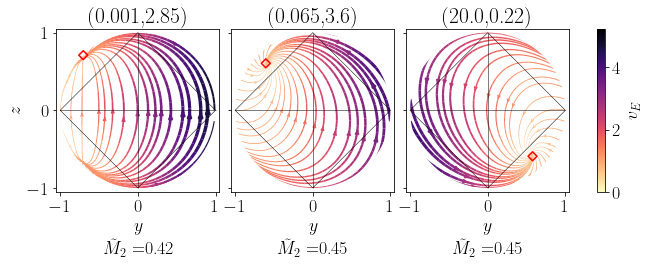

In [49]:
fig, axs = plt.subplots(1, 3, figsize = [10,3], sharex = True, sharey = True)
th_arr = np.linspace(0, 2*np.pi, 300)
Uc, Vc = np.meshgrid(np.linspace(-1, 1, 5), np.linspace(-1, 1, 5))
#Ucirc = Uc[np.where(Uc**2+Vc**2<=1)]
#Vcirc = Vc[np.where(Uc**2+Vc**2<=1)]
#plt.streamplot(Ucirc, Vcirc, fy(0, Ucirc, Vcirc, G, g, 0), fz(0, Ucirc, Vcirc, G, g, 0))
plt.subplots_adjust(wspace = 0.07, hspace = 0.05)
maxspeed_gG = np.zeros((3,1))
minspeed_gG = np.zeros((3,1))
for m in range(1):
    for n in range(3):
        g, G = g_G_arr[n,:]
        ydot = fy(0, Uc, Vc, G, g, 0)
        zdot = fz(0, Uc, Vc, G, g, 0)
        #aux_speed = np.sqrt(ydot**2+zdot**2)/gap_maxI(g,G)
        aux_speed = np.sqrt(ydot**2+zdot**2)
        #print(gap(g_arr[n], G_arr[m]))
        maxspeed_gG[n,m] = np.max(aux_speed)
        minspeed_gG[n,m] = np.min(aux_speed)
print(maxspeed_gG)
print(minspeed_gG)
maxSpeed = np.max(maxspeed_gG)
minSpeed = 0
#print(minSpeed)
cmap = mpl.colormaps['magma_r']
#normalizer = mpl.colors.Normalize(vmin = 0, vmax = maxSpeed)
#im = cm.ScalarMappable(norm=normalizer, cmap = cmap)
ytags_arr = ['a', 'b', 'c']
xtags_arr = ['1', '2', '3', '4']
for m in range(1):
    #axs[0].set_ylabel(r"$\Gamma/J =$"+str(G_arr[m])+"\n"+r"$z$")
    axs[0].set_ylabel(r"$z$")
    for n in range(3):
        g, G = g_G_arr[n,:]
        axs[n].set_xlabel(r"$y$"+"\n"+r"$\tilde M_2=$"+str(np.round(np.real(tildeSRE(g, G)),2)))
        #axs[m,n].text(-1.04,0.83, "("+ytags_arr[m]+xtags_arr[n]+")")
        axs[n].set_title(r"$($"+str(np.round(g_G_arr[n,0],3))+","+str(np.round(g_G_arr[n,1],2))+"$)$")
        axs[n].set_aspect('equal')
        #axs[m,n].plot(r_arr[1,:, m,n], r_arr[2,:, m,n], lw = 2, c = 'k')
        #pevol = axs[m,n].scatter(r_arr[1,:, m,n], r_arr[2,:, m,n], c = t_arr_Arr[:,m,n], s = 5, marker ='.', ls ='-', cmap ='magma', zorder = 30)
        axs[n].plot(np.cos(th_arr), np.sin(th_arr), c = 'w', lw = 1)
        ydot = fy(0, Uc, Vc, G, g, 0)
        zdot = fz(0, Uc, Vc, G, g, 0)
        #speed = np.sqrt(ydot**2+zdot**2)/(gap_maxI(g,G))
        speed = np.sqrt(ydot**2+zdot**2)
        p1 = axs[n].streamplot(Uc, Vc, ydot, zdot, color = speed, cmap = cmap,\
                                 linewidth = speed/np.max(speed)*4, norm = normalizer, broken_streamlines=False,\
                                 arrowsize = 0.6, arrowstyle = '->', density = 0.5)
        #p1_list.append(p1)
        #ax.streamplot(theta2D, r2D, fθ(r2D, theta2D, 0, g, G)/r2D,fr(r2D, theta2D, 0, g, G),)
        """if B(g_arr[n], G_arr[m])==0:
            y_st = 0
            z_st = 0
            axs[m,n].scatter(y_st, z_st, marker = '*', zorder = 0, c = 'r', s = 200)
        else:"""
        #rhoS = evec2(g_arr[n],G_arr[m])
        #print(rhoS)
        y_st = yBloch(g, G)
        z_st = zBloch(g, G)
        axs[n].scatter(y_st, z_st, marker = 'D', zorder = 30, c = 'none', ec = 'r', linewidths = 1.5, s = 40)
        #axs[m,n].scatter(y_st, z_st, marker = '+', zorder = 30, c = 'r', linewidths = 1.5, s = 80)
        axs[n].vlines(0, -1, 1, color = 'k', lw = .5, zorder = 20)
        axs[n].hlines(0, -1, 1, color = 'k', lw = .5, zorder = 20)
        #axs[n].text( 0.3, -1.7,r"$\tilde M_2=$"+str(np.round(np.real(tildeSRE(g, G)),2)))
        axs[n].plot([-1,0,1,0,-1],[0,1,0,-1,0], c = 'k', lw = .5, zorder = 20 )
        clip_patch = PathPatch(
          Path(np.transpose([np.cos(th_arr), np.sin(th_arr)])),
          edgecolor='none', facecolor='none')
        axs[n].add_patch(clip_patch)
        p1.lines.set_clip_path(clip_patch)
        for arrow_patch in axs[n].patches[-len(p1.arrows.get_paths())-1:]:
            arrow_patch.set_clip_path(clip_patch)

cb1 =fig.colorbar(im, ax=axs.ravel().tolist(), fraction = 0.03)

#cb1.set_label(r"$v_E/\Delta$")
cb1.set_label(r"$v_E$")
axs[0].set_xlim(-1.05, 1.05)
axs[0].set_ylim(-1.05, 1.05)
#axs[0,0].set_aspect('equal')
plt.savefig("SDQ_streamlines_evol_MagicStates.pdf", bbox_inches = 'tight')
plt.show()

In [32]:
def fr(r, θ, ϕ, g, G):
    return G*((2*g*G-1)*(r**2-1)*np.cos(θ)-g*G*r*np.sin(θ)**2)
def fθ(r, θ, ϕ, g, G):
    return -G*(1-2*g*G+g*G*r*np.cos(θ))*np.sin(θ)/r-2*np.sin(ϕ)